In [1]:
# Install RDKit in Colab (uncomment if needed)
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 51.9 MB/s eta 0:00:00


In [2]:
# Google Colab K-means Molecular Selection - CORRECTED VERSION
# Run this in Google Colab - all dependencies are pre-installed

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from datetime import datetime
import os
from tqdm import tqdm

# Set all random seeds for reproducibility
np.random.seed(42)
import random
random.seed(42)

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Descriptors

def count_protonatable_sites(smiles):
    """Count number of protonatable sites using TPSA approach"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0

    # Get TPSA contribution sites (protonatable atoms)
    tpsa = Chem.rdMolDescriptors._CalcTPSAContribs(mol)
    sites = np.argwhere(np.array(tpsa) > 0).flatten().tolist()

    # Filter to only N, O, S, P atoms
    valid_sites = 0
    for atom_idx in sites:
        atom = mol.GetAtomWithIdx(atom_idx)
        if atom.GetSymbol() in ['N', 'O', 'S', 'P'] and atom.GetFormalCharge() == 0:
            valid_sites += 1

    return valid_sites

def enhanced_molecular_screen(df, smiles_col, chunk_size=5000):
    """Screen molecules using enhanced criteria with chunked processing for speed."""

    def get_molecular_properties_batch(smiles_list):
        """Process a batch of SMILES for better performance"""
        results = []
        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                results.append([0, 0, 0, 0, False, True, True, 0])
                continue

            try:
                # Basic properties
                hbd = rdMolDescriptors.CalcNumHBD(mol)
                hba = rdMolDescriptors.CalcNumHBA(mol)
                heavy_atoms = mol.GetNumHeavyAtoms()
                mw = Descriptors.MolWt(mol)

                # Heteroatoms and charges - optimized checks
                symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]
                has_heteroatoms = any(x in symbols for x in ['N', 'O', 'S', 'P'])
                has_halogens = any(x in symbols for x in ['F', 'Cl', 'Br', 'I'])
                has_charges = any(atom.GetFormalCharge() != 0 for atom in mol.GetAtoms())

                # Protonatable sites
                protonatable_sites = count_protonatable_sites(smiles)

                results.append([hbd, hba, heavy_atoms, mw, has_heteroatoms,
                               has_halogens, has_charges, protonatable_sites])
            except:
                results.append([0, 0, 0, 0, False, True, True, 0])

        return results

    print("Calculating molecular properties in chunks...")

    # Initialize result columns
    property_columns = ['HBD', 'HBA', 'heavy_atoms', 'MW', 'has_heteroatoms',
                       'has_halogens', 'has_charges', 'protonatable_sites']

    # Process in chunks with progress bar
    total_chunks = (len(df) + chunk_size - 1) // chunk_size
    all_results = []

    for i in tqdm(range(0, len(df), chunk_size),
                  desc=f"Processing molecules (chunks of {chunk_size})",
                  total=total_chunks):
        chunk_end = min(i + chunk_size, len(df))
        smiles_chunk = df[smiles_col].iloc[i:chunk_end].tolist()

        # Process this chunk
        chunk_results = get_molecular_properties_batch(smiles_chunk)
        all_results.extend(chunk_results)

    # Convert results to DataFrame columns
    results_df = pd.DataFrame(all_results, columns=property_columns, index=df.index)

    # Add results to original DataFrame
    for col in property_columns:
        df[col] = results_df[col]

    # Apply all filters with progress indication
    print("Applying molecular filters...")
    original_len = len(df)

    # Pre-filter for speed (most restrictive first)
    print("  - Filtering by heteroatoms...")
    df = df[df['has_heteroatoms'] == True]

    print("  - Filtering by halogens and charges...")
    df = df[(df['has_halogens'] == False) & (df['has_charges'] == False)]

    print("  - Filtering by size and molecular weight...")
    df = df[(df['heavy_atoms'] >= 5) & (df['heavy_atoms'] <= 25) &
            (df['MW'] >= 50) & (df['MW'] <= 250)]

    print("  - Filtering by hydrogen bonding...")
    df = df[(df['HBD'] >= 1) & (df['HBA'] >= 1)]

    print("  - Filtering by protonatable sites...")
    filtered = df[df['protonatable_sites'] >= 2]

    print(f"Enhanced filtering: {original_len} → {len(filtered)} molecules")
    print(f"Filters applied: heteroatoms (N/O/S/P), 5-25 heavy atoms, MW 50-250, ≥2 protonatable sites, no halogens, neutral")

    return filtered

def kmeans_molecular_selection_corrected(df, n_dft=256, n_pm7_per_dft=64, smiles_col='smiles'):
    """
    CORRECTED K-means based selection - PM7 molecules are evenly distributed within clusters.

    Parameters:
    - df: DataFrame with molecular data (filtered)
    - n_dft: Number of DFT calculations (cluster centers)
    - n_pm7_per_dft: Number of PM7 calculations per DFT molecule (evenly distributed)
    - smiles_col: Column name for SMILES strings

    Returns:
    - dft_df: DataFrame with DFT molecules
    - pm7_df: DataFrame with PM7 molecules (includes DFT molecules)
    - cluster_info_df: DataFrame with cluster information
    - filtered_df: DataFrame with tracked filtered molecules
    """

    print(f"Starting CORRECTED K-means molecular selection:")
    print(f"  - {n_dft} DFT calculations (cluster representatives)")
    print(f"  - {n_pm7_per_dft} PM7 calculations per DFT molecule (EVENLY DISTRIBUTED)")
    print(f"  - Total PM7 calculations: {n_dft * n_pm7_per_dft}")
    print(f"  - Clustering on filtered dataset: {len(df)} molecules")

    # Sort dataframe for reproducibility and track original indices
    df_sorted = df.sort_values('smiles').reset_index()
    df_sorted = df_sorted.rename(columns={'index': 'original_index'})

    coords = df_sorted[['latent_1', 'latent_2', 'latent_3']].values

    # Step 1: K-means clustering on FULL filtered dataset
    print(f"\nStep 1: Performing K-means clustering on all {len(df_sorted)} molecules...")
    print("  - Using sklearn KMeans with reproducible settings")

    # Use sklearn KMeans with fully reproducible settings
    kmeans = KMeans(
        n_clusters=n_dft,
        n_init=10,
        init='k-means++',
        random_state=42,    # Reproducible results
        verbose=0,          # Reduce output
        max_iter=300
    )

    cluster_labels = kmeans.fit_predict(coords)
    cluster_centers = kmeans.cluster_centers_

    print(f"  - Converged after {kmeans.n_iter_} iterations")
    print(f"  - Final inertia (within-cluster sum of squares): {kmeans.inertia_:.2f}")

    # Add cluster labels to dataframe
    df_sorted['cluster_id'] = cluster_labels

    # Calculate cluster information
    cluster_info = []
    for i in range(n_dft):
        cluster_mask = cluster_labels == i
        cluster_info.append({
            'cluster_id': i,
            'centroid_latent_1': cluster_centers[i][0],
            'centroid_latent_2': cluster_centers[i][1],
            'centroid_latent_3': cluster_centers[i][2],
            'n_molecules_in_cluster': np.sum(cluster_mask)
        })

    cluster_info_df = pd.DataFrame(cluster_info)

    print(f"Created {len(cluster_centers)} clusters from filtered dataset")
    print(f"Average cluster size: {len(df_sorted) / len(cluster_centers):.1f} molecules")
    print(f"Cluster size range: {cluster_info_df['n_molecules_in_cluster'].min()} - {cluster_info_df['n_molecules_in_cluster'].max()}")

    # Step 2: Select DFT molecules (closest to each cluster center)
    print(f"\nStep 2: Selecting DFT molecules (closest to cluster centers)...")
    dft_molecules = []
    dft_cluster_ids = []
    distances_to_centroid = []

    for i in tqdm(range(len(cluster_centers)), desc="Finding DFT molecules"):
        cluster_mask = cluster_labels == i
        if not np.any(cluster_mask):
            continue

        cluster_indices = np.where(cluster_mask)[0]
        cluster_coords = coords[cluster_mask]
        centroid = cluster_centers[i]

        # Find molecule closest to centroid with deterministic tie-breaking
        distances = np.linalg.norm(cluster_coords - centroid, axis=1)
        min_distance = np.min(distances)

        # Handle ties deterministically by using smallest original index
        min_indices = np.where(distances == min_distance)[0]
        if len(min_indices) > 1:
            tied_cluster_indices = cluster_indices[min_indices]
            closest_idx = tied_cluster_indices[0]  # First in sorted order (smallest original index)
        else:
            closest_idx = cluster_indices[np.argmin(distances)]

        dft_molecules.append(closest_idx)
        dft_cluster_ids.append(i)
        distances_to_centroid.append(min_distance)

    # Create DFT DataFrame
    dft_df = df_sorted.iloc[dft_molecules].copy()
    dft_df['calculation_type'] = 'DFT'
    dft_df['cluster_id'] = dft_cluster_ids
    dft_df['is_cluster_center'] = True
    dft_df['distance_to_centroid'] = distances_to_centroid
    dft_df['dft_representative'] = dft_df.index  # DFT molecules represent themselves
    dft_df['distance_to_dft'] = 0.0  # Distance to self is 0

    # Add centroid coordinates to DFT DataFrame
    dft_df = dft_df.merge(cluster_info_df[['cluster_id', 'centroid_latent_1', 'centroid_latent_2', 'centroid_latent_3']],
                         on='cluster_id', how='left')

    print(f"Selected {len(dft_df)} DFT molecules")
    print(f"Average distance DFT to centroid: {np.mean(distances_to_centroid):.4f}")

    # Step 3: CORRECTED - For each cluster, select evenly distributed PM7 molecules
    print(f"\nStep 3: Selecting EVENLY DISTRIBUTED PM7 molecules within each cluster...")
    print("  - Using K-means sub-clustering within each main cluster")

    pm7_molecules = []

    for i, cluster_id in enumerate(tqdm(range(n_dft), desc="Sub-clustering for PM7 selection")):
        cluster_mask = cluster_labels == cluster_id
        cluster_indices = np.where(cluster_mask)[0]
        cluster_coords = coords[cluster_mask]

        # Skip if cluster is too small
        if len(cluster_indices) < 2:
            print(f"Warning: Cluster {cluster_id} has only {len(cluster_indices)} molecules, skipping")
            continue

        # Determine number of PM7 molecules to select from this cluster
        n_pm7_cluster = min(n_pm7_per_dft, len(cluster_indices))

        if n_pm7_cluster <= 1:
            # Just select the DFT molecule
            selected_indices = [dft_molecules[i]]
        else:
            # Apply K-means sub-clustering within this cluster for even distribution
            sub_kmeans = KMeans(
                n_clusters=n_pm7_cluster,
                n_init=10,
                init='k-means++',
                random_state=42,
                verbose=0,
                max_iter=300
            )

            sub_cluster_labels = sub_kmeans.fit_predict(cluster_coords)
            sub_cluster_centers = sub_kmeans.cluster_centers_

            # For each sub-cluster, select the molecule closest to its center
            selected_indices = []
            for j in range(n_pm7_cluster):
                sub_cluster_mask = sub_cluster_labels == j
                if not np.any(sub_cluster_mask):
                    continue

                sub_cluster_coords = cluster_coords[sub_cluster_mask]
                sub_cluster_indices = cluster_indices[sub_cluster_mask]
                sub_centroid = sub_cluster_centers[j]

                # Find closest molecule to sub-cluster center
                distances = np.linalg.norm(sub_cluster_coords - sub_centroid, axis=1)
                min_distance = np.min(distances)

                # Deterministic tie-breaking
                min_indices = np.where(distances == min_distance)[0]
                if len(min_indices) > 1:
                    tied_indices = sub_cluster_indices[min_indices]
                    closest_idx = tied_indices[0]  # Smallest index
                else:
                    closest_idx = sub_cluster_indices[np.argmin(distances)]

                selected_indices.append(closest_idx)

        # Calculate distances from each PM7 molecule to the DFT representative
        dft_coords = coords[dft_molecules[i]]

        for idx in selected_indices:
            pm7_coords = coords[idx]
            distance_to_dft = np.linalg.norm(pm7_coords - dft_coords)
            distance_to_centroid = np.linalg.norm(pm7_coords - cluster_centers[cluster_id])

            pm7_molecules.append({
                'molecule_index': idx,
                'cluster_id': cluster_id,
                'dft_representative': dft_molecules[i],
                'distance_to_dft': distance_to_dft,
                'distance_to_centroid': distance_to_centroid,
                'is_cluster_center': idx == dft_molecules[i]
            })

    # Create PM7 DataFrame
    pm7_data = pd.DataFrame(pm7_molecules)
    pm7_df = df_sorted.iloc[pm7_data['molecule_index']].copy()
    pm7_df['calculation_type'] = 'PM7'
    pm7_df['cluster_id'] = pm7_data['cluster_id'].values
    pm7_df['dft_representative'] = pm7_data['dft_representative'].values
    pm7_df['distance_to_dft'] = pm7_data['distance_to_dft'].values
    pm7_df['distance_to_centroid'] = pm7_data['distance_to_centroid'].values
    pm7_df['is_cluster_center'] = pm7_data['is_cluster_center'].values

    # Add centroid coordinates to PM7 DataFrame
    pm7_df = pm7_df.merge(cluster_info_df[['cluster_id', 'centroid_latent_1', 'centroid_latent_2', 'centroid_latent_3']],
                         on='cluster_id', how='left')

    # Reset indices
    dft_df = dft_df.reset_index(drop=True)
    pm7_df = pm7_df.reset_index(drop=True)

    print(f"Selected {len(pm7_df)} PM7 molecules total")
    print(f"  - {len(pm7_df[pm7_df['is_cluster_center']])} are also DFT molecules")
    print(f"  - {len(pm7_df[~pm7_df['is_cluster_center']])} are PM7-only molecules")
    print(f"  - PM7 molecules are EVENLY DISTRIBUTED within each cluster")

    return dft_df, pm7_df, cluster_info_df, df_sorted

def main():
    """Main function with file path input"""

    # File input - modify this path to your chemical space file
    print("Please provide the path to your chemical space CSV file:")
    print("Example: /content/your_chemical_space.csv")

    # For testing, you can hardcode the path here:
    fname = input("Enter file path (or press Enter to upload): ").strip()

    if not fname:
        # Option: Upload file in Colab
        from google.colab import files
        print("Uploading file...")
        uploaded = files.upload()
        fname = list(uploaded.keys())[0]

    if not os.path.exists(fname):
        print(f"File not found: {fname}")
        return

    print(f"Loading chemical space from: {fname}")
    df = pd.read_csv(fname)

    # K-means selection parameters
    n_dft = 256  # Number of DFT calculations (cluster centers)
    n_pm7_per_dft = 64  # Number of PM7 calculations per DFT molecule
    use_enhanced_filters = True
    chunk_size = 5000  # Chunk size for property calculations

    print(f"Starting with {len(df)} molecules in chemical space")

    # Apply molecular filters
    if use_enhanced_filters:
        print("Using enhanced filtering (heteroatoms N/O/S/P, size, protonatable sites)...")
        filtered_df = enhanced_molecular_screen(df, 'smiles', chunk_size=chunk_size)
    else:
        print("Using simple filtering (Nitrogen + HBD/HBA)...")
        filtered_df = df[df['smiles'].apply(lambda x: 'N' in x if pd.notna(x) else False)]

    if len(filtered_df) == 0:
        print("No molecules passed filters. Consider relaxing criteria.")
        return

    print(f"After filtering: {len(filtered_df)} molecules available for selection")

    # Save filtered chemical space for tracking
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filter_type = "enhanced" if use_enhanced_filters else "simple"

    filtered_output = f'filtered_chemical_space_{filter_type}_{len(filtered_df)}molecules_{timestamp}.csv'
    filtered_df.to_csv(filtered_output, index=False)
    print(f"Saved filtered chemical space: {filtered_output}")

    # Perform CORRECTED K-means selection
    dft_df, pm7_df, cluster_info_df, tracked_filtered_df = kmeans_molecular_selection_corrected(
        filtered_df, n_dft=n_dft, n_pm7_per_dft=n_pm7_per_dft, smiles_col='smiles'
    )

    # Save results with tracking information

    # Save cluster information
    cluster_output = f'clusters_{filter_type}_{n_dft}clusters_{timestamp}.csv'
    cluster_info_df.to_csv(cluster_output, index=False)

    # Save DFT molecules
    dft_output = f'DFT_{filter_type}_{len(dft_df)}molecules_{timestamp}.csv'
    dft_df.to_csv(dft_output, index=False)

    # Save PM7 molecules
    pm7_output = f'PM7_{filter_type}_{len(pm7_df)}molecules_{timestamp}.csv'
    pm7_df.to_csv(pm7_output, index=False)

    # Save combined file
    combined_df = pd.concat([dft_df, pm7_df[~pm7_df['is_cluster_center']]], ignore_index=True)
    combined_output = f'hierarchical_{filter_type}_{len(combined_df)}molecules_{timestamp}.csv'
    combined_df.to_csv(combined_output, index=False)

    # Save tracked filtered molecules
    tracked_output = f'tracked_filtered_{filter_type}_{len(tracked_filtered_df)}molecules_{timestamp}.csv'
    tracked_filtered_df.to_csv(tracked_output, index=False)

    print(f"\nResults saved:")
    print(f"  - Filtered chemical space: {filtered_output}")
    print(f"  - Tracked filtered space: {tracked_output}")
    print(f"  - Cluster info: {cluster_output}")
    print(f"  - DFT molecules: {dft_output}")
    print(f"  - PM7 molecules: {pm7_output}")
    print(f"  - Combined file: {combined_output}")

    # Summary statistics
    print(f"\nSummary:")
    print(f"  - Original chemical space: {len(df):,} molecules")
    print(f"  - After filtering: {len(filtered_df):,} molecules ({100*len(filtered_df)/len(df):.1f}%)")
    print(f"  - {len(cluster_info_df)} K-means clusters created")
    print(f"  - {len(dft_df)} DFT calculations selected")
    print(f"  - {len(pm7_df)} PM7 calculations selected (EVENLY DISTRIBUTED)")
    print(f"  - Average PM7 per DFT: {len(pm7_df) / len(dft_df):.1f}")
    print(f"  - Unique molecules total: {len(combined_df)}")
    print(f"  - Average distance DFT to centroid: {dft_df['distance_to_centroid'].mean():.4f}")
    print(f"  - Average distance PM7 to DFT: {pm7_df['distance_to_dft'].mean():.4f}")
    print(f"  - Average cluster size: {cluster_info_df['n_molecules_in_cluster'].mean():.1f}")

    # Download results (Colab specific)
    try:
        from google.colab import files
        files.download(dft_output)
        files.download(pm7_output)
        files.download(combined_output)
        files.download(filtered_output)
    except:
        print("Not in Colab environment - files saved locally")

    return dft_df, pm7_df, cluster_info_df, tracked_filtered_df

if __name__ == "__main__":
    main()

Please provide the path to your chemical space CSV file:
Example: /content/your_chemical_space.csv
Enter file path (or press Enter to upload): /content/StructureEmbeddingMany-TransformMorganFingerprints-WriteAllMorganFingerprints-ConcatCSV-2D-AK-AKEC-009.csv
Loading chemical space from: /content/StructureEmbeddingMany-TransformMorganFingerprints-WriteAllMorganFingerprints-ConcatCSV-2D-AK-AKEC-009.csv
Starting with 1301790 molecules in chemical space
Using enhanced filtering (heteroatoms N/O/S/P, size, protonatable sites)...
Calculating molecular properties in chunks...


Processing molecules (chunks of 5000): 100%|██████████| 261/261 [11:22<00:00,  2.61s/it]


Applying molecular filters...
  - Filtering by heteroatoms...
  - Filtering by halogens and charges...
  - Filtering by size and molecular weight...
  - Filtering by hydrogen bonding...
  - Filtering by protonatable sites...
Enhanced filtering: 1301790 → 821435 molecules
Filters applied: heteroatoms (N/O/S/P), 5-25 heavy atoms, MW 50-250, ≥2 protonatable sites, no halogens, neutral
After filtering: 821435 molecules available for selection
Saved filtered chemical space: filtered_chemical_space_enhanced_821435molecules_20250904_140333.csv
Starting CORRECTED K-means molecular selection:
  - 256 DFT calculations (cluster representatives)
  - 64 PM7 calculations per DFT molecule (EVENLY DISTRIBUTED)
  - Total PM7 calculations: 16384
  - Clustering on filtered dataset: 821435 molecules

Step 1: Performing K-means clustering on all 821435 molecules...
  - Using sklearn KMeans with reproducible settings
  - Converged after 184 iterations
  - Final inertia (within-cluster sum of squares): 33611

Finding DFT molecules: 100%|██████████| 256/256 [00:01<00:00, 231.35it/s]


Selected 256 DFT molecules
Average distance DFT to centroid: 0.0620

Step 3: Selecting EVENLY DISTRIBUTED PM7 molecules within each cluster...
  - Using K-means sub-clustering within each main cluster


Sub-clustering for PM7 selection: 100%|██████████| 256/256 [01:35<00:00,  2.68it/s]


Selected 16384 PM7 molecules total
  - 6 are also DFT molecules
  - 16378 are PM7-only molecules
  - PM7 molecules are EVENLY DISTRIBUTED within each cluster

Results saved:
  - Filtered chemical space: filtered_chemical_space_enhanced_821435molecules_20250904_140333.csv
  - Tracked filtered space: tracked_filtered_enhanced_821435molecules_20250904_140333.csv
  - Cluster info: clusters_enhanced_256clusters_20250904_140333.csv
  - DFT molecules: DFT_enhanced_256molecules_20250904_140333.csv
  - PM7 molecules: PM7_enhanced_16384molecules_20250904_140333.csv
  - Combined file: hierarchical_enhanced_16634molecules_20250904_140333.csv

Summary:
  - Original chemical space: 1,301,790 molecules
  - After filtering: 821,435 molecules (63.1%)
  - 256 K-means clusters created
  - 256 DFT calculations selected
  - 16384 PM7 calculations selected (EVENLY DISTRIBUTED)
  - Average PM7 per DFT: 64.0
  - Unique molecules total: 16634
  - Average distance DFT to centroid: 0.0620
  - Average distance PM

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plot the candidates selected

Auto-detecting CSV files in /content/...
✓ Background: tracked_filtered_enhanced_821435molecules_20250904_140333.csv
✓ DFT data:   DFT_enhanced_256molecules_20250904_140333.csv
✓ PM7 data:   PM7_enhanced_16384molecules_20250904_140333.csv
✓ Found 256 clusters in data. Will generate distinct colors.
Generating 256 unique aesthetic colors...
Plot saved to: /content/chemical_space_cluster_analysis.png


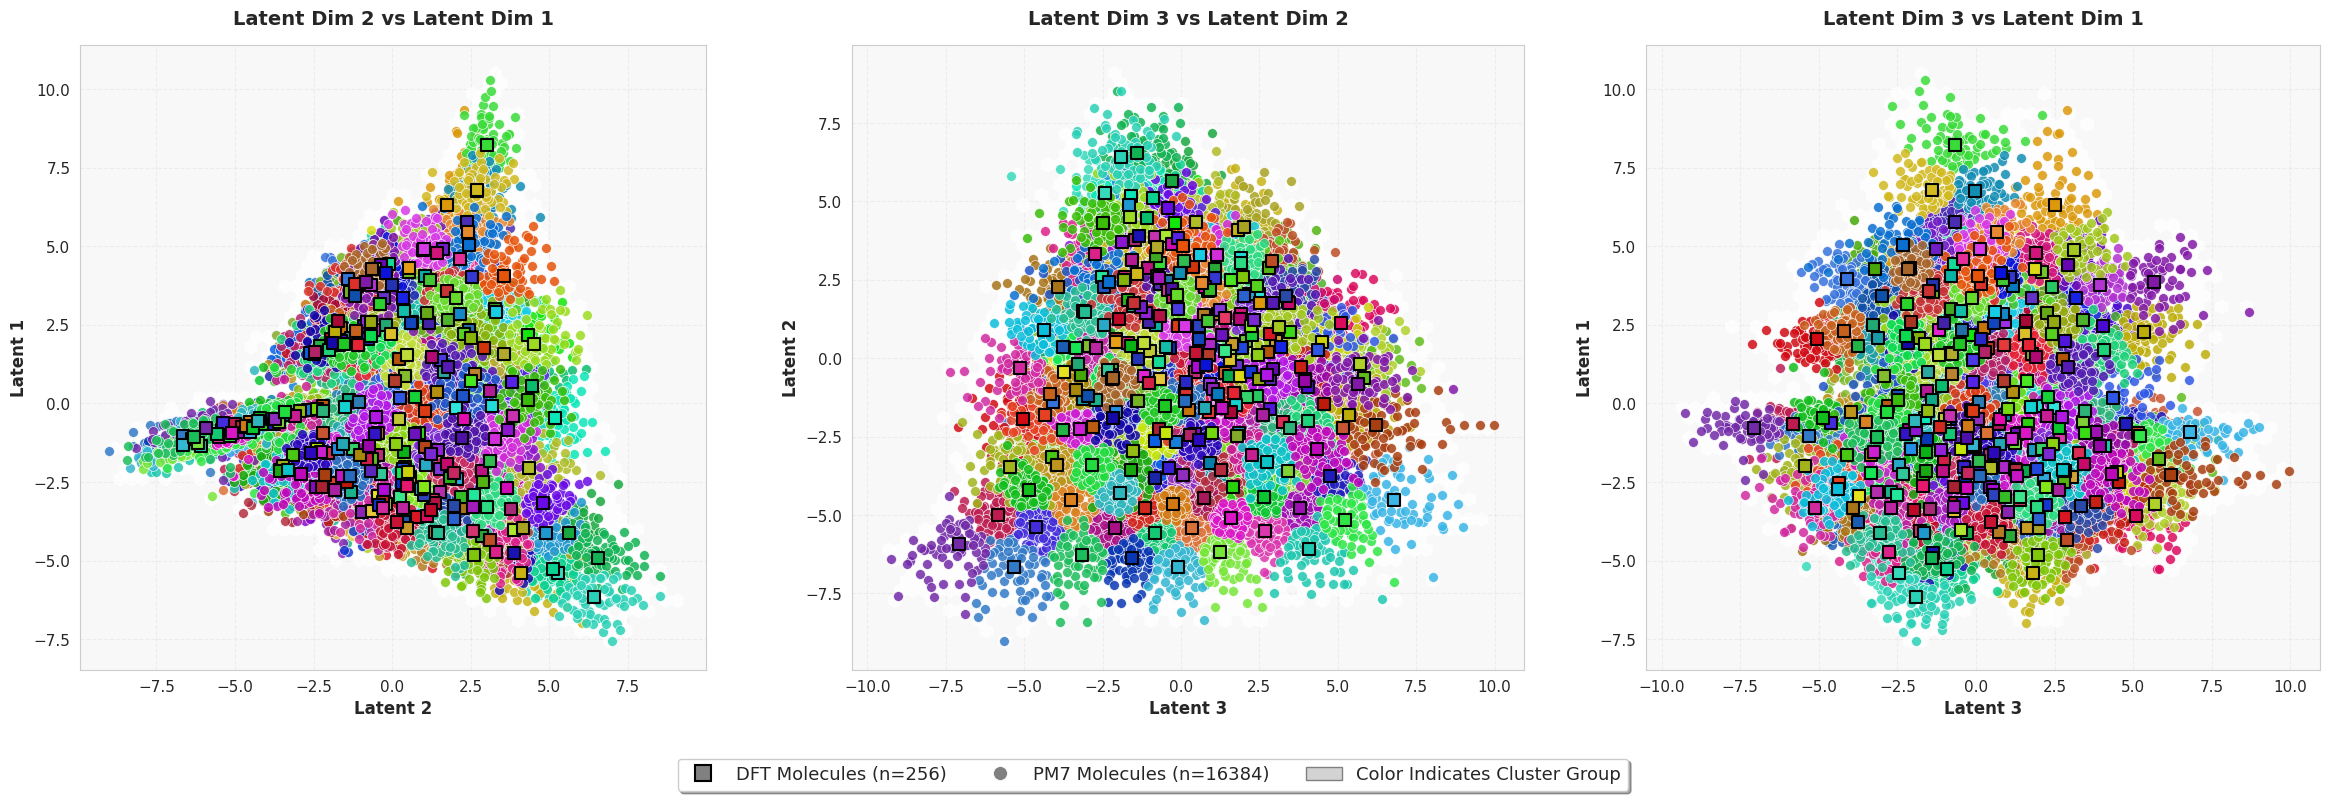


CHEMICAL LATENT SPACE ANALYSIS SUMMARY
Background chemical space: 821,435 molecules
DFT molecules (squares): 256 (0.03% coverage)
PM7 molecules (circles): 16,384 (1.99% coverage)
Clusters with unique colors: 256 (from custom aesthetic generator)

✓ Visualization completed successfully!


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import hsv_to_rgb # Import for custom color generation
import os
import warnings

warnings.filterwarnings('ignore')

def generate_distinct_colors(n_colors):
    """
    Generate n aesthetically pleasing, distinct colors by controlling HSV properties.
    This avoids overly saturated "neon" colors while maintaining distinctness.

    Parameters:
    - n_colors: The number of unique colors required.

    Returns:
    - A list of shuffled, vibrant but pleasing RGB color tuples.
    """
    colors = []

    # Generate colors by evenly spacing hues and controlling saturation/value
    for i in range(n_colors):
        # Evenly space the hue across the color wheel
        hue = i / n_colors

        # Keep saturation and value high, but not at the maximum, to avoid harsh colors.
        # A little variation is added for more distinctness.
        saturation = 0.75 + (i % 5) * 0.05  # Varies between 0.75 and 0.95
        value = 0.9 - (i % 7) * 0.04       # Varies between 0.9 and 0.68

        rgb_color = hsv_to_rgb((hue, saturation, value))
        colors.append(rgb_color)

    # Shuffle the list of colors. This is CRITICAL to ensure that clusters
    # that are spatially close get visually distinct colors.
    np.random.seed(42) # Use a seed for reproducible color assignments
    np.random.shuffle(colors)

    return colors

def plot_chemical_latent_space(fname, dft_df, pm7_df, save_path=None,
                              fig_size=(24, 8), font_size=14,
                              background_alpha=0.8,
                              point_size=60,
                              show_density=True, density_gridsize=50,
                              show_cluster_colors=True):
    """
    Creates a latent space visualization with aesthetically pleasing, distinct colors.
    """
    plt.style.use('default')
    sns.set_style("whitegrid")
    background_df = pd.read_csv(fname)
    fig, axes = plt.subplots(1, 3, figsize=fig_size, facecolor='white')
    fig.patch.set_facecolor('white')

    if show_cluster_colors and 'cluster_id' in pm7_df.columns:
        unique_clusters = sorted(pm7_df['cluster_id'].unique())
        n_clusters = len(unique_clusters)
        print(f"Generating {n_clusters} unique aesthetic colors...")
        distinct_colors = generate_distinct_colors(n_clusters)
        cluster_colors = {cluster_id: distinct_colors[i]
                         for i, cluster_id in enumerate(unique_clusters)}
    else:
        cluster_colors = None; n_clusters = 0

    subplot_configs = [
        {'coords': ['latent_2', 'latent_1'], 'title': 'Latent Dim 2 vs Latent Dim 1'},
        {'coords': ['latent_3', 'latent_2'], 'title': 'Latent Dim 3 vs Latent Dim 2'},
        {'coords': ['latent_3', 'latent_1'], 'title': 'Latent Dim 3 vs Latent Dim 1'}
    ]

    for ax, config in zip(axes, subplot_configs):
        x_col, y_col = config['coords']
        bg_coords = background_df[[x_col, y_col]].values

        if show_density:
            ax.hexbin(bg_coords[:, 0], bg_coords[:, 1], gridsize=density_gridsize,
                     cmap='Greys', alpha=background_alpha, mincnt=1, zorder=1)

        if show_cluster_colors and cluster_colors:
            for cluster_id, color in cluster_colors.items():
                cluster_pm7 = pm7_df[pm7_df['cluster_id'] == cluster_id]
                cluster_dft = dft_df[dft_df['cluster_id'] == cluster_id]

                if not cluster_pm7.empty:
                    ax.scatter(cluster_pm7[x_col], cluster_pm7[y_col],
                              s=point_size, facecolors=color,
                              edgecolors='white', linewidths=0.5,
                              alpha=0.85, # CHANGED: Reduced opacity for softer look
                              marker='o', zorder=4)

                if not cluster_dft.empty:
                    ax.scatter(cluster_dft[x_col], cluster_dft[y_col],
                              s=point_size + 20, facecolors=color,
                              edgecolors='black', linewidths=1.5,
                              alpha=1.0, marker='s', zorder=5)
        else: # Fallback
            ax.scatter(pm7_df[x_col], pm7_df[y_col], s=point_size, facecolors='#4682B4', edgecolors='white', zorder=4)
            ax.scatter(dft_df[x_col], dft_df[y_col], s=point_size+20, facecolors='#FF6347', edgecolors='black', zorder=5)

        ax.set_xlabel(f'{x_col.replace("_", " ").title()}', fontsize=font_size, fontweight='600')
        ax.set_ylabel(f'{y_col.replace("_", " ").title()}', fontsize=font_size, fontweight='600')
        ax.set_title(config['title'], fontsize=font_size+2, fontweight='bold', pad=15)
        ax.grid(True, alpha=0.3, color='#D3D3D3', linestyle='--')
        ax.set_facecolor('#F8F8F8')
        ax.tick_params(axis='both', labelsize=font_size-1)
        ax.set_aspect('equal', adjustable='box')

    legend_elements = [
        Line2D([0], [0], marker='s', color='w', markerfacecolor='gray',
               markersize=12, markeredgecolor='black', markeredgewidth=1.5,
               label=f'DFT Molecules (n={len(dft_df)})', linestyle='None'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               markersize=10, markeredgecolor='white', markeredgewidth=0.5,
               label=f'PM7 Molecules (n={len(pm7_df)})', linestyle='None'),
        Patch(facecolor='lightgray', edgecolor='gray', label='Color Indicates Cluster Group')
    ]

    fig.legend(handles=legend_elements, loc='upper center',
               bbox_to_anchor=(0.5, 0.1), ncol=3,
               fontsize=font_size+1, frameon=True, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Plot saved to: {save_path}")

    plt.show()

    print("\n" + "="*65)
    print("CHEMICAL LATENT SPACE ANALYSIS SUMMARY")
    print("="*65)
    print(f"Background chemical space: {len(background_df):,} molecules")
    print(f"DFT molecules (squares): {len(dft_df):,} ({len(dft_df)/len(background_df)*100:.2f}% coverage)")
    print(f"PM7 molecules (circles): {len(pm7_df):,} ({len(pm7_df)/len(background_df)*100:.2f}% coverage)")
    if n_clusters > 0:
        print(f"Clusters with unique colors: {n_clusters} (from custom aesthetic generator)")
    print("="*65)

# AUTO-EXECUTION SCRIPT
def main():
    try:
        print("Auto-detecting CSV files in /content/...")
        csv_files = [f for f in os.listdir('/content/') if f.endswith('.csv')]

        if len(csv_files) < 3:
            raise ValueError(f"Need at least 3 CSV files, found {len(csv_files)}")

        largest_file = max(csv_files, key=lambda x: os.path.getsize(f'/content/{x}'))
        dft_files = [f for f in csv_files if 'dft' in f.lower()]
        pm7_files = [f for f in csv_files if 'pm7' in f.lower()]

        if not dft_files: raise ValueError("No DFT file found (must contain 'dft' in filename)")
        if not pm7_files: raise ValueError("No PM7 file found (must contain 'pm7' in filename)")

        fname = f'/content/{largest_file}'
        dft_df = pd.read_csv(f'/content/{dft_files[0]}')
        pm7_df = pd.read_csv(f'/content/{pm7_files[0]}')

        print(f"✓ Background: {largest_file}")
        print(f"✓ DFT data:   {dft_files[0]}")
        print(f"✓ PM7 data:   {pm7_files[0]}")

        if 'cluster_id' not in pm7_df.columns or 'cluster_id' not in dft_df.columns:
            print("\nWarning: 'cluster_id' column not found in both PM7 and DFT data. Clustering disabled.")
            show_colors = False
        else:
            show_colors = True
            n_clusters = len(pm7_df['cluster_id'].unique())
            print(f"✓ Found {n_clusters} clusters in data. Will generate distinct colors.")

        plot_chemical_latent_space(
            fname=fname, dft_df=dft_df, pm7_df=pm7_df,
            save_path='/content/chemical_space_cluster_analysis.png',
            fig_size=(24, 8), font_size=12,
            background_alpha=0.75, point_size=50,
            show_density=True, show_cluster_colors=show_colors
        )
        print("\n✓ Visualization completed successfully!")

    except Exception as e:
        print(f"\n❌ An error occurred: {e}")
        print("Please check that 'dft', 'pm7', and a large background CSV file exist in /content/.")

if __name__ == "__main__":
    main()